In [82]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io as scio
import h5py
import numpy as np
import time
import math
import os
import json
from pathlib import Path
from tmm_acc import coh_tmm_normal_spol_spec_d
import argparse
from HybridNet import HybridNet,NoisyHybridNet
from NoiseLayer import *
from test_hybnet import *

device_test = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [83]:
model_folders = Path('./nets/hybnet/').glob('20230720_*')

results = {}
testing_SNR = [60,50,40,30,20,10,0]
data = scio.loadmat(r'D:\zf-py\graduate2\PCSED\data\ICVL_400-1000-5_100K.mat')['data']

for model_folder in model_folders:
    testing_model = Hybnet_folder(model_folder)
    training_SNR = testing_model.noise_cfg['SNR']

    results[training_SNR] = {}
    for SNR in testing_SNR:
        testing_model.load_model(device_test)
        testing_model.change_noise_layer(SNR,1)
        

        pred_T = testing_model.TargetCurves_FMN
        simu_T = testing_model.T

        pred_loss, _ = testing_model.eval(data,pred_T, device_test)
        simu_loss, _ = testing_model.eval(data,simu_T, device_test)

        results[training_SNR][SNR] = {'pred_loss':np.mean(pred_loss),'simu_loss':np.mean(simu_loss)}
    


        




In [84]:
k = sorted(results.keys(),reverse=True)

results = {key:results[key] for key in k}

In [85]:
results

{60: {60: {'pred_loss': 4.3278662e-05, 'simu_loss': 4.3558855e-05},
  50: {'pred_loss': 0.0004260741, 'simu_loss': 0.00042617595},
  40: {'pred_loss': 0.0047871303, 'simu_loss': 0.0048132786},
  30: {'pred_loss': 0.03813305, 'simu_loss': 0.03826252},
  20: {'pred_loss': 0.2174151, 'simu_loss': 0.21460204},
  10: {'pred_loss': 1.289818, 'simu_loss': 1.299013},
  0: {'pred_loss': 10.272958, 'simu_loss': 10.293897}},
 30: {60: {'pred_loss': 0.0016163242, 'simu_loss': 0.0016162192},
  50: {'pred_loss': 0.0016204932, 'simu_loss': 0.0016197569},
  40: {'pred_loss': 0.00165895, 'simu_loss': 0.0016604314},
  30: {'pred_loss': 0.002165576, 'simu_loss': 0.002153526},
  20: {'pred_loss': 0.0107782995, 'simu_loss': 0.010779567},
  10: {'pred_loss': 0.10838878, 'simu_loss': 0.10868431},
  0: {'pred_loss': 1.1071522, 'simu_loss': 1.1083372}},
 20: {60: {'pred_loss': 0.006181109, 'simu_loss': 0.006180876},
  50: {'pred_loss': 0.006177728, 'simu_loss': 0.0061779083},
  40: {'pred_loss': 0.006139539, '

In [93]:
print(f'{4.33E-05:.10f}')

0.0000433000


In [88]:
import pandas as pd

pred_results = {}
simu_results = {}
for key in results.keys():
    pred_results[key] = [results[key][SNR]['pred_loss'] for SNR in results[key].keys()]
    simu_results[key] = [results[key][SNR]['simu_loss'] for SNR in results[key].keys()]

pred_results = pd.DataFrame(pred_results,index=testing_SNR)
simu_results = pd.DataFrame(simu_results,index=testing_SNR)


In [90]:
# save as csv
pred_results.to_csv('./results/SNR_pred_results.csv')

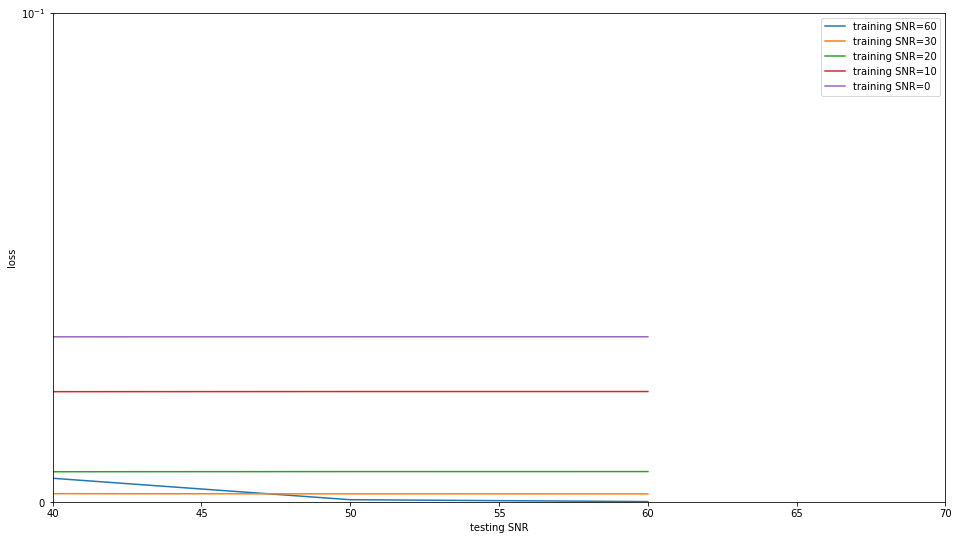

In [64]:
plt.figure(figsize=(16,9))
testing_SNR = [60,50,40,30,20,10,0]
for k,v in results.items():
    plt.plot(testing_SNR,[results[k][SNR]['pred_loss'] for SNR in testing_SNR],label=f'training SNR={k}')
plt.legend()
plt.xlabel('testing SNR')
plt.ylabel('loss')
plt.yscale('symlog')
plt.xlim(40,70)
plt.ylim(0,0.1)
plt.show()

In [140]:
testing_model = Hybnet_folder(Path(r'D:\zf-py\graduate2\PCSED\nets\hybnet\20230718_043421'))
testing_model.load_model(device_test)
print(testing_model.noise_cfg['SNR'], testing_model.noise_cfg['alpha'])

10 1


In [141]:
testing_SNR = [60,50,40,30,20,10,0]
data = scio.loadmat(r'D:\zf-py\graduate2\PCSED\data\ICVL_400-1000-5_100K.mat')['data']

results = {}
for SNR in testing_SNR:
    
    testing_model.change_noise_layer(SNR,1)
    

    pred_T = testing_model.TargetCurves_FMN
    simu_T = testing_model.T

    pred_loss, pred_result = testing_model.eval(data,pred_T, device_test)
    simu_loss, simu_result = testing_model.eval(data,simu_T, device_test)
    results[SNR] = {'pred_loss':np.mean(pred_loss),'simu_loss':np.mean(simu_loss),'pred_result':pred_result,'simu_result':simu_result}

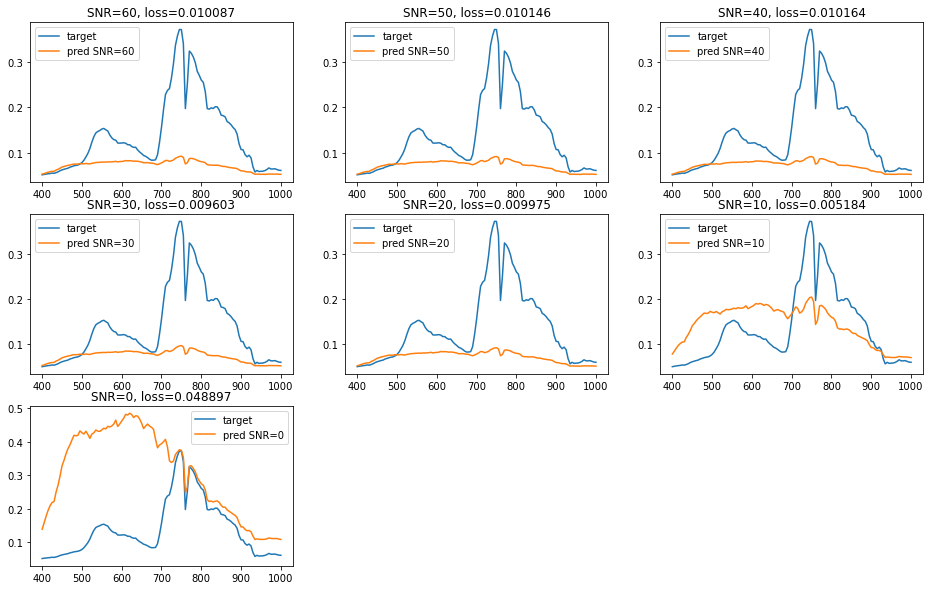

In [142]:
idx = 3002
plt.figure(figsize=(16,10))
for lidx,SNR in enumerate(testing_SNR):
    plt.subplot(3,3,lidx+1)
    plt.plot(testing_model.WL,data[idx,:],label='target')
    plt.plot(testing_model.WL,results[SNR]['pred_result'][idx,:],label=f'pred SNR={SNR}')
    # plt.plot(testing_model.WL,results[SNR]['simu_result'][idx,:],label=f'simu SNR={SNR}')
    loss = (data[idx,:]-results[SNR]['pred_result'][idx,:])**2
    plt.title(f'SNR={SNR}, loss={np.mean(loss):.6f}')
    plt.legend()
plt.show()
    